<a href="https://colab.research.google.com/github/1900690/Agro-Meteorological-Grid-Square-Data/blob/main/1km%E3%83%A1%E3%83%83%E3%82%B7%E3%83%A5%E6%B0%97%E8%B1%A1%E6%83%85%E5%A0%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#農研機構 メッシュ農業気象データシステムの使い方

観測・計算方法についての論文

[実況値と数値予報，平年値を組み合わせたメッシュ気温・降水量データの作成](https://www.jstage.jst.go.jp/article/cib/16/0/16_J-16-028/_article/-char/ja/)

In [1]:
#@title 利用登録時に申請したIDとパスワードを入力
# ライブラリ（メッシュデータ処理のために必要）
!pip install -q netCDF4
!pip install -q japanize-matplotlib
import numpy as np
import os
import sys
import shutil
from google.colab import userdata
import japanize_matplotlib
from google.colab import files
japanize_matplotlib.japanize()

ID = '' # @param {type:"string"}
passward = '' # @param {type:"string"}
if ID == '':
  ID= userdata.get("ID")
  passward= userdata.get("passward")

if os.path.exists('/content/AMGSDS_map.html'):
  os.remove('/content/AMGSDS_map.html')

!wget -q https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/releases/download/amd_tools4/amd_tools4.zip
!wget -q https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/releases/download/AMGSDS_map/AMGSDS_map.html

shutil.unpack_archive('/content/amd_tools4.zip')
os.remove('/content/amd_tools4.zip')
sys.path.append('/content/AMD_Tools4.py')#passを通す


path = "/content/AMD_Tools4.py"
line_num = 50 # 上書きする行番号(場合によっては変わる)
tempid = "USER='"+ID+"'\n" # 上書きしたい内容
temppass = "PASSWORDS=['"+passward+"','"+passward+"']\n" # 上書きしたい内容
font="plt.rcParams['font.family'] = 'Meiryo'\n"

with open(path) as file:
    list = file.readlines()
list[line_num] = tempid
list[line_num+1] = temppass
#list[line_num+38] = font
with open(path, mode="w") as file:
    file.writelines(list)


import AMD_Tools4 as amd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#@title 調べる場所の経度と緯度を調べる
#@markdown ←の➤を押してファイルをダウンロード、そのファイルを開き情報が欲しい区画の経度と緯度をコピーする

#@markdown ※google mapから経度緯度を取得してもよい
from google.colab import files
files.download('/content/AMGSDS_map.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<p align="center">
  <img src="https://github.com/1900690/Agro-Meteorological-Grid-Square-Data/blob/main/%E8%AA%AC%E6%98%8E%E7%94%BB%E5%83%8F/%E5%BA%A7%E6%A8%99%E5%8F%96%E5%BE%97.png?raw=1" width=40%>
</p>

#1.日別の気象変化を折れ線グラフで表示


TMP_mea (61, 1, 1) Tile


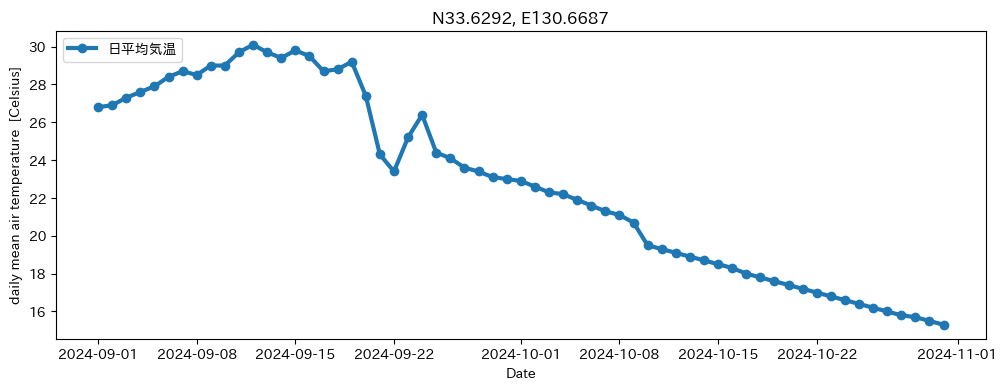

In [9]:
#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigou = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['1mm以上の降水の有無', 'OPR'], ['日照時間', 'SSD'], ['全天日射量', 'GSR'], ['下向き長波放射量', 'DLR'], ['日平均相対湿度', 'RH'], ['日平均風速', 'WIND'], ['積雪深', 'SD'], ['積雪相当水量', 'SWE'], ['日降雪相当水量', 'SFW'], ['予報気温の確からしさ', 'PTMP']]
#情報名を入力する
欲しい情報 = '日平均気温' # @param ["日平均気温", "日最高気温", "日最低気温", "降水量", "1mm以上の降水の有無", "日照時間", "全天日射量", "下向き長波放射量", "日平均相対湿度", "日平均風速", "積雪深", "積雪相当水量", "日降雪相当水量", "予報気温の確からしさ"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in yousokigou:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigou.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigou[j][1]

#@markdown ###期間の指定

#@markdown ※26日先までの予測が用意されているのは日平均気温、日最高気温、日最低気温、降水量、日照時間、予報気温の確からしさです。そのほかは９日先までの予測が用意されています
初め= '2024-09-01' # @param {type:"date"}
終わり = '2024-10-31' # @param {type:"date"}
itsu= [初め, 終わり]

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
緯度 = 33.6294 # @param {type:"number"}
経度 = 130.667 # @param {type:"number"}

doko= [緯度,緯度,経度,経度]

#@markdown ###平年値を取得するかどうか

#@markdown ※平年値がない値を選択するとエラーになります
平年値 = False # @param {type:"boolean"}
cli=平年値

# 設定に基づき気象データを取得
if cli==True:
  #設定に基づき気象データを取得
  data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)
  Ta = data[:,0,0]     #入れ物の入れ替え(3次元から1次元へ)
  #設定に基づき平年値を取得
  data,tim,lat,lon,nam,uni = amd.GetMetData(nani,itsu,doko,cli=True,namuni=True)  # 戻り値は6個になる
  Tn = data[:,0,0]   #入れ物の入れ替え(3次元から1次元へ)
  amd.linefig(tim, Ta,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel=欲しい情報,
      ref=Tn,
      filename="日別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png',
      llabelref='平年値')
else:
  data, tim, lat, lon,nam,uni = amd.GetMetData(nani, itsu, doko,namuni=True)
  Ta = data[:,0,0]     #入れ物の入れ替え(3次元から1次元へ)
  amd.linefig(tim, Ta,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel=欲しい情報,
      filename="日別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png',
      llabelref='平年値')

In [ ]:
#@title グラフをダウンロード
files.download("日別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
#@title .CSVファイルでデータをダウンロード
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d') for d in tim]
header = 'メッシュ値, 緯度, 経度, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(data, lat, lon, addlalo=True, header=header, filename="日別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

files.download("日別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

#2.メッシュデータの分布図を作成

TMP_max (1, 120, 160) Tile


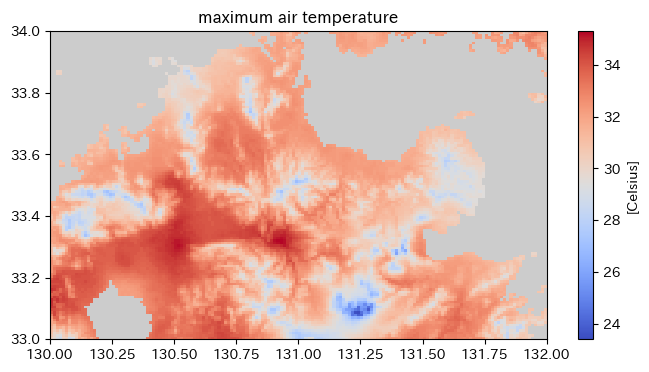

In [ ]:
#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigou = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['1mm以上の降水の有無', 'OPR'], ['日照時間', 'SSD'], ['全天日射量', 'GSR'], ['下向き長波放射量', 'DLR'], ['日平均相対湿度', 'RH'], ['日平均風速', 'WIND'], ['積雪深', 'SD'], ['積雪相当水量', 'SWE'], ['日降雪相当水量', 'SFW'], ['予報気温の確からしさ', 'PTMP']]
#情報名を入力する
欲しい情報 = '日最高気温' # @param ["日平均気温", "日最高気温", "日最低気温", "降水量", "1mm以上の降水の有無", "日照時間", "全天日射量", "下向き長波放射量", "日平均相対湿度", "日平均風速", "積雪深", "積雪相当水量", "日降雪相当水量", "予報気温の確からしさ"]
#リスト（情報名）の中から入力した都市名と一致するものを検索する
for i in yousokigou:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigou.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigou[j][1]

#@markdown ###期間の指定

#@markdown ※26日先までの予測が用意されているのは日平均気温、日最高気温、日最低気温、降水量、日照時間、予報気温の確からしさです。そのほかは９日先までの予測が用意されています
日付= '2024-09-01' # @param {type:"date"}
itsu= [日付, 日付]

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
小さいほうの緯度 = 33.0 # @param {type:"number"}
小さいほうの経度 = 130.0 # @param {type:"number"}
大きいほうの緯度 = 34.0 # @param {type:"number"}
大きいほうの経度 = 132.0 # @param {type:"number"}

doko= [小さいほうの緯度,大きいほうの緯度,小さいほうの経度,大きいほうの経度]

# 設定に基づき気象データを取得
data, tim, lat, lon, nam, uni = amd.GetMetData(nani, itsu, doko, namuni=True)
Ta = data[0,:,:]
amd.mapfig(Ta, lat, lon,
        #minmax=[-10,40],
        #figsize=[5,5],
        figtitle=f'{nam}',
        barlabel=f'[{uni}]',
        filename=欲しい情報+'.png',
        cmap='coolwarm')

In [ ]:
#@title 地理院地図と重ね合わせて表示
#@markdown ←の➤を押してファイルをダウンロード、その中の１つ **.html** をファイルをダブルクリックしてください。


amd.PutGSI_Map(Ta, lat, lon, filename=欲しい情報)

files.download(欲しい情報+'.html')
files.download(欲しい情報+'_l.png')
files.download(欲しい情報+'_o.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TMP (1465, 1, 1) Hourly


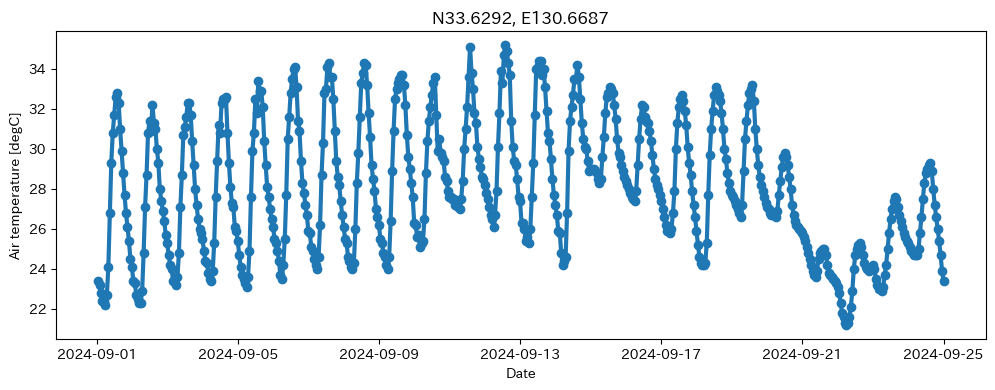

In [12]:
#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigoutime = [['気温', 'TMP'], ['相対湿度', '%'], ['下向き長波放射', 'W/m2']]
#情報名を入力する
欲しい情報 = '気温' # @param ["気温", "相対湿度", "下向き長波放射"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in yousokigoutime:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigoutime.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigoutime[j][1]

#@markdown ###期間の指定

#@markdown ※９日先までの予測が用意されています
初め= '2024-09-01' # @param {type:"date"}
終わり = '2024-10-31' # @param {type:"date"}
itsu= [初め+'T01', 終わり+'T24']

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
緯度 = 33.6294 # @param {type:"number"}
経度 = 130.667 # @param {type:"number"}

doko= [緯度,緯度,経度,経度]


#設定に基づき気象データを取得
data, timh, lat, lon, nam, uni = amd.GetMetDataHourly(nani, itsu, doko, namuni=True)
Ta = data[:,0,0]     #入れ物の入れ替え(3次元から1次元へ)
#設定に基づき平年値を取得
Th = data[:,0,0]
lat_sc = lat[0]
lon_sc = lon[0]

amd.linefig(timh,Th,
         title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
         filename="時別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png',
         ylabel=f'{nam} [{uni}]')

In [17]:
#@title グラフをダウンロード
files.download("時別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
#@title .CSVファイルでデータをダウンロード
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d-%H') for d in timh]
header = 'メッシュ値, 緯度, 経度, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(data,lat,lon, addlalo=True, header=header, filename="時別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

files.download("時別"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#3.温暖化シナリオデータの取得


Cli_TMP_mea (365, 1, 1) Tile
TMP_mea (365, 1, 1) Tile MIROC5 RCP8.5)


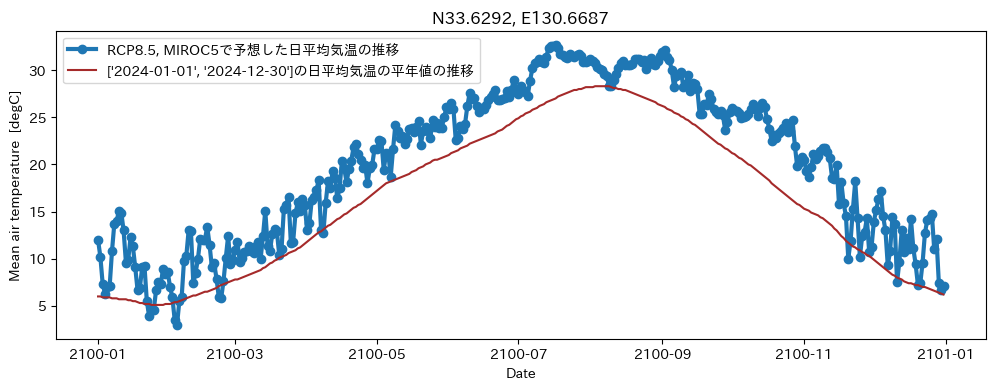

In [35]:
#@markdown ###ほしい情報の種類を指定
#気象要素記号一覧作成
yousokigouhist = [['日平均気温', 'TMP_mea'], ['日最高気温', 'TMP_max'], ['日最低気温', 'TMP_min'], ['降水量', 'APCP'], ['全天日射量', 'GSR']]
欲しい情報 = '日平均気温' #@param ["日平均気温", "日最高気温", "日最低気温", "降水量", "全天日射量"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in yousokigouhist:
    if 欲しい情報 in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yousokigouhist.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
nani = yousokigouhist[j][1]

#@markdown ###比較する現在の期間の指定
初め= '2024-01-01' # @param {type:"date"}
終わり = '2024-12-30' # @param {type:"date"}
itsu_now= [初め, 終わり]

#@markdown ###比較する未来の期間の指定
初め= '2100-01-01' # @param {type:"date"}
終わり = '2100-12-31' # @param {type:"date"}
itsu_future= [初め, 終わり]

#@markdown ###位置の指定

#@markdown ※６桁あれば十分
緯度 = 33.6294 # @param {type:"number"}
経度 = 130.667 # @param {type:"number"}

doko= [緯度,緯度,経度,経度]

#@markdown ###予測シナリオを選択
yosokusinario = [['4℃上昇シナリオ', 'RCP8.5'], ['2℃上昇シナリオ','RCP2.6']]
選択するシナリオ = '4℃上昇シナリオ' #@param ["4℃上昇シナリオ", "2℃上昇シナリオ"]
#リスト（情報名）の中から入力したものと一致するものを検索する
for i in yosokusinario:
    if 選択するシナリオ in i:
        result = True
        break
result
#一致したものがリスト（data）の何行目かを調べる
j = yosokusinario.index(i)
#要素記号コードの指定（該当行の1列目が都市コード）
scenario = yosokusinario[j][1]

# 気象データの取得
model = 'MIROC5'

#@markdown ※予測に使用するモデルは'MIROC5'です。

#設定に基づき平年値を取得
data, tim, lat, lon = amd.GetMetData(nani, itsu_now, doko, cli=True)
Tmax = data[:,0,0]

# シナリオデータの取得
data, tim, lat, lon, nam, uni = amd.GetSceData(nani, itsu_future, doko, model, scenario, namuni=True)
Tsmax = data[:,0,0]

#設定に基づき平年値を取得
Th = data[:,0,0]
lat_sc = lat[0]
lon_sc = lon[0]

amd.linefig(tim, Tsmax,
      title=f'N{lat[0]:.4f}, E{lon[0]:.4f}',
      ylabel=f'{nam}  [{uni}]',
      llabel=f'{scenario}, {model}'+'で予想した'+str(欲しい情報)+'の推移',
      filename="温暖化予測"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png',
      ref=Tmax,
      llabelref=str(itsu_now)+'の'+str(欲しい情報)+'の平年値の推移')

In [36]:
#@title グラフをダウンロード
files.download("温暖化予測"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
#@title .CSVファイルでデータをダウンロード
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d') for d in tim]
header = 'メッシュ値, 緯度, 経度, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(data,lat,lon, addlalo=True, header=header, filename="温暖化予測"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

files.download("温暖化予測"+欲しい情報+str(f'N{lat[0]:.4f}, E{lon[0]:.4f}')+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##引用
このノートブックには[農研機構メッシュ農業気象データThe Agro-Meteorological Grid Square Data, NARO大野ら、2016](https://amu.rd.naro.go.jp/)を利用した。

##文献
● 大野宏之、佐々木華織、大原源二、中園　江、2016：実況値と数値予報、平年値を組み合わせたメッシュ気温・降水量データの作成. 生物と気象、16、71-79．

● 佐々木華織、西森基貴、根本　学、2022：メッシュ農業気象データ利用マニュアルVer.5．農研機構、77pp．